## 必要なライブラリのインポート
- numpy,chainer系
- ファイル操作系
- 画像操作

In [1]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import iterators, optimizers, training
from chainer.training import extensions
from chainer.cuda import to_cpu

import os
import glob
from PIL import Image

## modelの定義(AlexNetぽい構造の何か)

In [2]:
# class AlexNet(chainer.Chain):
# #     insize = 100
#     def __init__(self):
#         super(AlexNet, self).__init__(
#             conv1=L.Convolution2D(3, 96, 11, stride=4),
#             conv2=L.Convolution2D(96, 256, 5, pad=2),
#             conv3=L.Convolution2D(256, 384, 3, pad=1),
#             conv4=L.Convolution2D(384, 284, 3, pad=1),
#             conv5=L.Convolution2D(284, 256, 3, pad=1),
#             fc6=L.Linear(1024, 4096),
#             fc7=L.Linear(4096, 1024),
#             fc8=L.Linear(1024, 3),
#         )

#     def __call__(self, x, t=None):
#         h = x
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
#         h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
#         h = F.relu(self.conv3(h))
#         h = F.relu(self.conv4(h))
#         h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
#         h = F.dropout(F.relu(self.fc6(h)))
#         h = F.dropout(F.relu(self.fc7(h)))
#         if t is not None:
#             loss = F.softmax_cross_entropy(h, t)
#             chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
#             return loss
#         else:
#             return to_cpu(F.softmax(self.fc8(h)).data)

In [3]:
class AlexNet(chainer.Chain):
#     insize = 100
    def __init__(self):
        super(AlexNet, self).__init__(
            conv1=L.Convolution2D(3, 96, 11, stride=4),
            conv2=L.Convolution2D(96, 256, 5, pad=2),
            conv3=L.Convolution2D(256, 384, 3, pad=1),
            conv4=L.Convolution2D(384, 384, 3, pad=1),
            conv5=L.Convolution2D(384, 256, 3, pad=1),
            fc6=L.Linear(9216, 4096),
            fc7=L.Linear(4096, 1024),
            fc8=L.Linear(1024, 50),
        )

    def __call__(self, x, t=None):
        h = x
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv1(h))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)))
        h = F.dropout(F.relu(self.fc7(h)))
        if t is not None:
            loss = F.softmax_cross_entropy(h, t)
            chainer.report({'loss': loss, 'accuracy': F.accuracy(h, t)}, self)
            return loss
        else:
            return to_cpu(F.softmax(self.fc8(h)).data)

## データセットのディレクトリ名の取得
以降、ディレクトリごとにラベルつけていく

In [4]:
dataset_dir = "dataset"
label_names = os.listdir(dataset_dir)

In [5]:
# label_names = label_names[0:2]

In [6]:
_labels = []
_images = []

In [7]:
for i, label in enumerate(label_names):
    for f in glob.glob("%s/%s/*"%(dataset_dir,label)):
        img = Image.open(f)
        img = np.array(img.resize((227,227)))
        for j in range(20):
            _labels.append(i)
            _images.append(img)

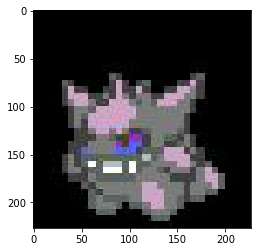

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(_images[0])

In [9]:
# 正規化
images = np.array(_images, dtype=np.float32) / 255.0
labels = np.array(_labels, dtype=np.int32)

## chainerで扱えるようにRGBの層を手前に持ってくる

In [10]:
images = images.transpose(0,3,1,2)

In [11]:
images[0].shape
labels.shape

(1000,)

## 画像と正解ラベルのペアを作成する

In [12]:
x_train = chainer.datasets.TupleDataset(images, labels)

In [13]:
x_train[0]

(array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32), 0)

## 入力に渡すiteratorの作成

In [14]:
train_iter = iterators.SerialIterator(x_train, batch_size=100, shuffle=True)

## modelの作成

In [15]:
model = AlexNet()

## 最適化手法の選択

In [16]:
optimizer = optimizers.Adam()
optimizer.setup(model)

## undaterとtrainerの作成
device=0で処理が0番GPUに投げられるはず  
訓練結果はresultディレクトリに作成されるはず

In [17]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

/home/c0115334ef/anaconda3/lib/python3.6/site-packages/chainer/cuda.py:84: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cupy-with-cudnn-and-nccl).
  'cuDNN is not enabled.\n'


In [18]:
trainer = training.Trainer(updater, (100, 'epoch'), out='result')

## Logの出力設定

In [19]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss']))
trainer.extend(extensions.ProgressBar())

In [20]:
trainer.run()

epoch       main/accuracy  main/loss 
1           0.018          8.78608     
2           0.02           6.9128      
3           0.017          6.73271     
4           0.015          6.65834     
5           0.028          6.5784      
6           0.016          6.60756     
7           0.023          6.5401      
8           0.047          6.44167     
9           0.069          6.41529     
10          0.109          6.18158     
     total [#####.............................................] 10.00%
this epoch [..................................................]  0.00%
       100 iter, 10 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
11          0.132          6.13761     
12          0.164          5.94502     
13          0.163          5.89546     
14          0.174          5.77333     
15          0.157          5.89999     
16          0.185          5.80201     
17          0.192          5.74467     
18          0.202          5.6738      
19  

## 【祝】訓練データに対する判別率10%突破！